In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
photlib = ctypes.CDLL("./c_src/cwrapper.so")

In [2]:
def fb(phi, m):
    if not hasattr(phi, "__len__"):
        phi = np.array([phi])
    if not hasattr(m, "__len__"):
        m = np.ones_like(phi)*m
    phi = (ctypes.c_double * len(phi)).from_buffer(phi)
    m = (ctypes.c_double * len(m)).from_buffer(m)
    e = (ctypes.c_double * len(phi)).from_buffer(np.zeros(len(phi)))
    j = ctypes.c_int(len(phi))
    photlib.F.restype = None
    photlib.F(phi, m, e, j)
    return np.array(e)

def eb(phi, m):
    if not hasattr(phi, "__len__"):
        phi = np.array([phi])
    if not hasattr(m, "__len__"):
        m = np.ones_like(phi)*m
    phi = (ctypes.c_double * len(phi)).from_buffer(phi)
    m = (ctypes.c_double * len(m)).from_buffer(m)
    e = (ctypes.c_double * len(phi)).from_buffer(np.zeros(len(phi)))
    j = ctypes.c_int(len(phi))
    photlib.E.restype = None
    photlib.E(phi, m, e, j)
    return np.array(e)

def pb(phi, n, m):
    if not hasattr(phi, "__len__"):
        phi = np.array([phi])
    if not hasattr(m, "__len__"):
        m = np.ones_like(phi)*m
    if not hasattr(n, "__len__"):
        n = np.ones_like(phi)*n
    phi = (ctypes.c_double * len(phi)).from_buffer(phi)
    m = (ctypes.c_double * len(m)).from_buffer(m)
    n = (ctypes.c_double * len(n)).from_buffer(n)
    e = (ctypes.c_double * len(phi)).from_buffer(np.zeros(len(phi)))
    j = ctypes.c_int(len(phi))
    photlib.P.restype = None
    photlib.P(phi, n, m, e, j)
    return np.array(e)

def fkp(phi, n, m):
    return fb(phi, m), eb(phi, m), pb(phi, n, m)

In [ ]:
def bdj(phi, n, m):
    if not hasattr(phi, "__len__"):
        s = np.sin(np.array([phi]))
    else:
        s = np.sin(phi)
    if not hasattr(n, "__len__"):
        n = np.ones_like(s)*n
    if not hasattr(m, "__len__"):
        m = np.ones_like(s)*m
    s = (ctypes.c_double * len(s)).from_buffer(s)
    n = (ctypes.c_double * len(n)).from_buffer(n)
    m = (ctypes.c_double * len(m)).from_buffer(m)
    b = (ctypes.c_double * len(s)).from_buffer(np.zeros(len(s)))
    d = (ctypes.c_double * len(s)).from_buffer(np.zeros(len(s)))
    j = (ctypes.c_double * len(s)).from_buffer(np.zeros(len(s)))
    k = ctypes.c_int(len(s))
    photlib.BDJ_arrays.restype = None
    photlib.BDJ_arrays(b, d, j, s, n, m, k)
    return np.array(b), np.array(d), np.array(j)

CPU times: user 1.21 ms, sys: 93 µs, total: 1.31 ms
Wall time: 658 µs


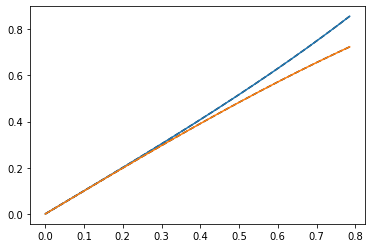

In [3]:
from scipy.special import ellipkinc, ellipeinc

phi = np.linspace(0, np.pi/4, 1000)
n = 0.7
m = 0.8
%time f, e, p = fkp(phi, n, m)

plt.plot(phi, f, 'k--')
plt.plot(phi, e, 'k--')

plt.plot(phi, ellipkinc(phi, m))
plt.plot(phi, ellipeinc(phi, m))

In [4]:
# numerical integration of the primitive integral
from scipy.integrate import quad

prim = lambda phi, r, b: ((1 - (1 - r**2 - b**2 + 2*r*b*np.cos(phi))**(3/2))*r*(r-b*np.cos(phi))
                          /(b**2+r**2-2*b*r*np.cos(phi)))/3
G = lambda r, b, phi1, phi2: quad(prim, phi1, phi2, args=(r, b))[0]

In [5]:
def abc(r, b):
    if b==0:
        return 0, 0, 0
    elif (b+r) == 1:
        return 0, 0, 0
    elif b==r:
        if r == 0.5:
            return 0, 0, 0
        else:
            beta = (1-4*r**2)/9
            alpha = 4*(2*r**2-1)/9
            gamma = 0
            return alpha, beta, gamma
    else:
        x = np.sqrt(1 - (b-r)**2)
        alpha = (7*r**2 + b**2 - 4) * x / 9
        beta = (r**4 + b**4 + r**2 - b**2 * (5+2*r**2) + 1) / 9 / x
        gamma = (b + r) / (b - r) / 3 / x
        return alpha, beta, gamma

def R(r, b, phi):
    if b==0:
        if r==0:
            return phi / 3
        else:
            return phi * (1 - (1-r**2)**(3/2)) / 3
    elif b==r:
        if r == 0.5:
            return phi / 6 - (1/3) * np.sin(phi/2) * (1 - np.sin(phi/2)**2 / 3)
        else:
            return phi / 6 - 2 * r**2 * np.sin(phi) * np.sqrt(1 + 2 * r**2 * (np.cos(phi)-1)) / 9
    elif (b+r)==1:
        return (phi/6 - np.arctan((2*r-1)/np.tan(phi/2))/3 
                + np.arctan(2*np.sqrt(r*b)*np.sin(phi/2)/(1-2*r)) / 3
                + np.pi * np.sqrt(1-4*r*b) / (2*r-1) / 6
                + (2/9) * np.sqrt(b*r) * (2*r*(5*r-2) - 2*b*r*np.cos(phi) - 3) * np.sin(phi/2))
    else:
        return (phi/6 - np.arctan((b+r)/(b-r) * np.tan(phi/2))/3 
                - (2*b*r/9) * np.sin(phi) * np.sqrt(1-b**2-r**2+2*b*r*np.cos(phi)))
    
def snm(r, b, phi):
    if b==0:
        s, n, m = 0, 0, 0
    elif b==r:
        s, n, m = phi/2, 0, 4*r**2
    else:
        s, n, m = phi/2, -4*r*b/(b-r)**2, 4*r*b / (1 - (r-b)**2)
    if m > 1:
        m = 1.0
    return s, n, m
    
def G_analytic(r, b, phi1, phi2):
    alpha, beta, gamma = abc(r, b)
    
    if phi1 < 0:
        f1, k1, p1 = fkp(*snm(r, b, -phi1))
        R1 = R(r, b, -phi1)
        if phi2 < 0:
            f2, k2, p2 = fkp(*snm(r, b, -phi2))
            R2 = R(r, b, -phi2)
            return (alpha * (k1 - k2) + beta * (f1 - f2) + gamma * (p1 - p2) + (R1 - R2))[0]
        else:
            f2, k2, p2 = fkp(*snm(r, b, phi2))
            R2 = R(r, b, phi2)
            return (alpha * (k1 + k2) + beta * (f1 + f2) + gamma * (p1 + p2) + (R1 + R2))[0]
    else:
        f1, k1, p1 = fkp(*snm(r, b, phi1))
        R1 = R(r, b, phi1)
        f2, k2, p2 = fkp(*snm(r, b, phi2))
        R2 = R(r, b, phi2)
        return (alpha * (k2 - k1) + beta * (f2 - f1) + gamma * (p2 - p1) + (R2 - R1))[0]
    
def G_analytic_bdj(r, b, phi1, phi2):
    alpha, beta, gamma = abc_bdj(r, b)
    
    if phi1 < 0:
        b1, d1, j1 = bdj(*snm(r, b, -phi1))
        R1 = R(r, b, -phi1)
        if phi2 < 0:
            b2, d2, j2 = bdj(*snm(r, b, -phi2))
            R2 = R(r, b, -phi2)
            return (alpha * (b1 - b2) + beta * (d1 - d2) + gamma * (j1 - j2) + (R1 - R2))[0]
        else:
            b2, d2, j2 = bdj(*snm(r, b, phi2))
            R2 = R(r, b, phi2)
            return (alpha * (b1 + b2) + beta * (d1 + d2) + gamma * (j1 + j2) + (R1 + R2))[0]
    else:
        b1, d1, j1 = bdj(*snm(r, b, phi1))
        R1 = R(r, b, phi1)
        b2, d2, j2 = fkp(*snm(r, b, phi2))
        R2 = R(r, b, phi2)
        return (alpha * (b2 - b1) + beta * (d2 - d1) + gamma * (j2 - j1) + (R2 - R1))[0]

In [6]:
print(G_analytic(0.2, 0.8, -np.pi/2, -np.pi/3))
print(G_analytic_bdj(0.2, 0.8, -np.pi/2, -np.pi/3))
print(G(0.2, 0.8, -np.pi/2, -np.pi/3))

-0.00029715458805840145


NameError: name 'bdj' is not defined

CPU times: user 42.2 ms, sys: 2.13 ms, total: 44.4 ms
Wall time: 46 ms
CPU times: user 58.7 ms, sys: 4.15 ms, total: 62.9 ms
Wall time: 74.9 ms


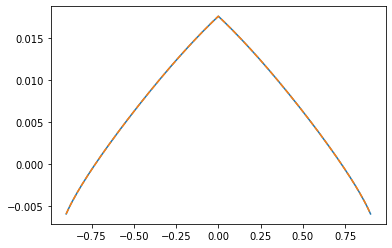

In [14]:
b = np.concatenate((np.linspace(0.9, 0, 100), np.linspace(0, 0.9, 100)))
bp = np.concatenate((np.linspace(-0.9, 0, 100), np.linspace(0, 0.9, 100)))
%time f = np.array([G(0.1, b, -np.pi/8, np.pi) for b in b])
%time f_analytic = np.array([G_analytic(0.1, b, -np.pi/8, np.pi) for b in b])
plt.plot(bp, f)
plt.plot(bp, f_analytic, '--')
#plt.plot(bp, f_analytic_bdj, '.')

#plt.plot(0.0, G_analytic(0.5, 0.0, -np.pi/4, np.pi/4), 'ko')
#plt.plot(0.5, G_analytic(0.5, 0.5, -np.pi/4, np.pi/4), 'ko')
#plt.plot(0.5, G_analytic(0.5, 0.5, -np.pi/4, np.pi/4), 'ko')
#print(G_analytic(0.2, 0.8, 0, np.pi/2))

#plt.ylim(-0.3, 0.3)

In [ ]:
#plt.plot(bp, snm(0.5, b, -np.pi/2)[2])
plt.plot(bp, [snm(0.5, b, np.pi/2)[1] for b in b])
#plt.ylim(-1000, 1)

In [ ]:
alpha, beta, gamma = np.array([np.array(abc(0.5, b)) for b in b]).T
f = np.array([fkp(*snm(0.5, b, np.pi/2)) for b in b]).T[0][2]
plt.plot(bp, f)
plt.ylim(-1, 1)

In [ ]:
alpha, beta, gamma = np.array([np.array(abc_bdj(0.5, b)) for b in b]).T
f = np.array([fkp(*snm(0.5, b, np.pi/2)) for b in b]).T[0][2]
plt.plot(bp, f, '.')
plt.ylim(0, 2)

In [ ]:
b = np.concatenate((np.linspace(0.9, 0, 901), np.linspace(0, 0.9, 901)))
bp = np.concatenate((np.linspace(-0.9, 0, 901), np.linspace(0, 0.9, 901)))
f = [G(0.2, b, -np.pi, np.pi) for b in b]
f_analytic = [G_analytic(0.2, b, -np.pi, np.pi) for b in b]

plt.plot(bp, f, '.')
plt.plot(bp, f_analytic, '.')
#plt.ylim(-1, 1)
plt.axvline(0.2)
plt.axvline(-0.2)

In [ ]:
r = np.linspace(0.01, 0.4, 100)
#np.array([fkp(*snm(r, r, np.pi/4))[1] for r in r]).T
plt.plot(r, [G(r, 1-r, -np.pi/2, np.pi/2) for r in r])
plt.plot(r, [G_analytic(r, 1-r, -np.pi/2, np.pi/2) for r in r])
#plt.plot(r, [fkp(*snm(r, r, np.pi/2))[0] for r in r])
#plt.plot(r, [abc(r, r)[0]*fkp(*snm(r, r, np.pi/2))[0] for r in r])
#plt.plot(r, [abc(r, r)[1] for r in r])
#plt.plot(r, [fkp(*snm(r, r, np.pi/2))[1] for r in r])
#plt.plot(r, [abc(r, r)[0]*fkp(*snm(r, r, np.pi/2))[0] + abc(r, r)[1]*fkp(*snm(r, r, np.pi/2))[1]+ R(r, r, np.pi/2) for r in r])

In [ ]:
print([fkp(*snm(1-b, b, 0))[2] for b in b])
print([snm(1-b, b, 0)[1] for b in b])

In [ ]:
[G_analytic(1-b, b, 0, np.pi) for b in b]

In [ ]:
n = np.linspace(0, -100, 100)
phi = np.ones_like(n)*np.pi/2
plt.plot(n, fkp(phi, n, 0.5)[2])

In [ ]:
r = 0.1
b = np.linspace(0.15, 1, 1000)
phi = np.ones_like(b)*np.pi/2
plt.plot(b, fkp(phi, -(1-(r-b)**2)/(r-b)**2, 0.5)[2])

In [ ]:
-(1-(r-b)**2)/(r-b)**2

In [ ]:
np.sign(-12.2)

In [ ]:
2**2 + 1

In [ ]:
import numpy as np

In [ ]:
%timeit np.arctan(0.5)

In [ ]:
from scipy.special import ellipeinc, ellipkinc

In [ ]:
%timeit ellipeinc(0.5, 0.5)

In [ ]:
%timeit ellipkinc(0.5, 0.5)